### Necessary Imports and Installs

In [1]:
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Model
from tensorflow.keras.layers import Add, GlobalAveragePooling2D, Conv2D, Dense, AveragePooling2D, BatchNormalization, Dropout, Flatten, Lambda, Input, Activation
from tensorflow.keras.callbacks import Callback, TensorBoard as TensorboardCallback, EarlyStopping
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

from huggingface_hub import notebook_login, HfFolder, HfApi
import utils
from utils import data_loader
from utils import custom_generators
from utils import visualization
from utils.augmentation import data_augmentation_transformer, data_augmentation_cnn

import numpy as np
import matplotlib.pyplot as plt
import time
import opendatasets as od
import warnings

from importlib import reload

import logging
from GLC.data_loading.common import load_patch

%pylab inline --no-import-all
from pathlib import Path
import pandas as pd
import sys
import time
import datetime

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Setting environment variables
hours = 4

tf.random.set_seed(42)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# Change this path to adapt to where you downloaded the data
DATA_PATH = Path("./geolifeclef-2022-lifeclef-2022-fgvc9/")

warnings.filterwarnings('ignore')

# Set-up Tensorboard
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/

# Choose pre-trained transformer
fp16=True

# Train in mixed-precision float16
# Comment this line out if you're using a GPU that will not benefit from this
if fp16:
    keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


In [3]:
# Login to HuggingFace
# notebook_login()

### GPU Parallelization:

In [4]:
# The maximun value for num_threads is dependent on amount of CPU cores:
# amount of CPU cores * vCPUs to core ratio = theoretical max of NUM_THREADS
NUM_THREADS = 64

# The more batches we prefetch, the less idle the GPUs will be. 
# To check GPU usage:
# 1. Run nvidia-smi -l 1 from the terminal to monitor the GPU usage during training. 
# 2. Try to get close to 100% for all GPUs by adjusting the value below (and the two above). Due to the overhead
#    from tf.distribute.MirroredStrategy(), you won't be able to consistently get 100% for all GPUs. But try to 
#    get close.
# 3. Be aware that RAM limits the amount of batches you can prefetch.
PRE_FETCH_NUM_BATCHES = int(NUM_THREADS * 20) 

In [5]:
# Apply DATA Auto-sharding policy
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA

In [6]:
# for distributed training (that is, using multiple GPUs for data parallelization)
# https://www.tensorflow.org/guide/distributed_training#use_tfdistributestrategy_with_keras_modelfit
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


# Dataset Creation

## Load Image Data

In [7]:
NUM_CLASSES = 30

In [8]:
reload(utils.data_loader)
loader = data_loader.DataLoader(data_path="./geolifeclef-2022-lifeclef-2022-fgvc9/")

train_ids, y_train, val_ids, y_val, test_ids, y_test = loader.subset_labels_dense(num_labels=NUM_CLASSES, min_obs=1000, max_obs=2000)

In [9]:
from sklearn.utils import shuffle 
train_ids, y_train = shuffle(train_ids, y_train)

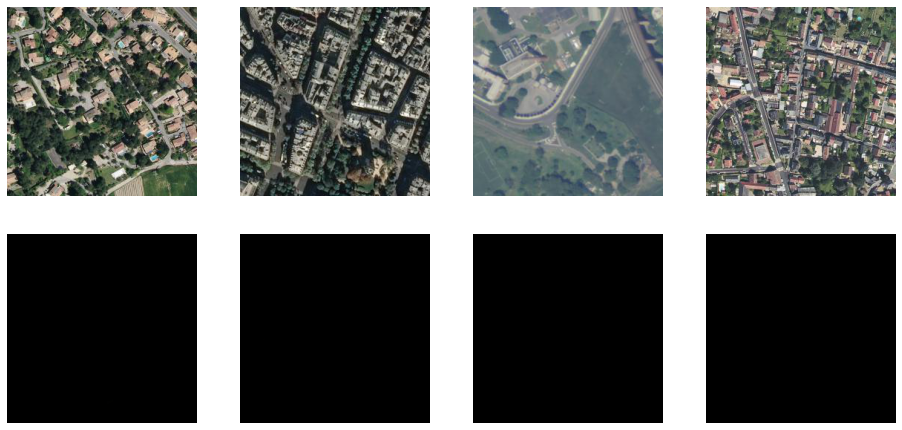

In [10]:
# Used to set image_size based on chosen transformer
visualization.visualize_augmentation(train_ids, DATA_PATH, num_images=4, contrast=0.2, flip='horizontal', rotation=0.3)

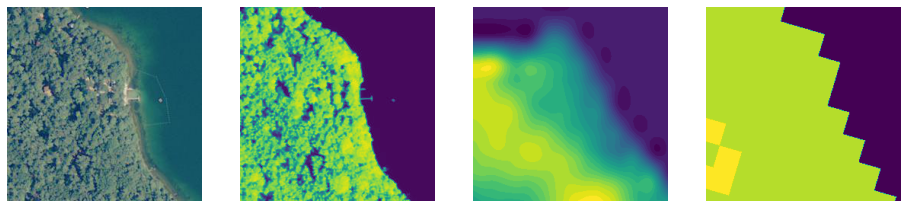

In [11]:
visualization.visualize_sat(train_ids, image=45, data_path=DATA_PATH)

## Load Tabular Data

In [12]:
df_train, df_val, df_test = loader.load_environmental_data(train_ids, val_ids, test_ids)

In [13]:
# Impute all missing values to calculate accurate loss
from sklearn.impute import SimpleImputer

# impute train data
imputer = SimpleImputer()
column_names = df_train.columns.values
row_names = df_train.index.values

df_imp_train = pd.DataFrame(imputer.fit_transform(df_train))
df_imp_train.index = row_names
df_imp_train.columns = column_names

# impute val data
row_names = df_val.index.values

df_imp_val = pd.DataFrame(imputer.transform(df_val))
df_imp_val.index = row_names
df_imp_val.columns = column_names

# Do not impute test data, instead drop nan rows
drop_idx = df_test.iloc[list(pd.isnull(df_test).any(1).values.nonzero()[0])].index.values
test_ids_temp = []
y_test_temp = []
for i, el in enumerate(zip(test_ids, y_test)):
    idx, label = el
    if idx not in drop_idx:
        test_ids_temp.append(idx)        
        y_test_temp.append(label)

test_ids = np.array(test_ids_temp)
y_test = np.array(y_test)

df_test = df_test.dropna()

In [14]:
# Assign numeric token for embedding (-200 because it never appears in the data - heuristic)
# sep = -200
# input_cells = df_imp_train.assign(token=sep)
# val_cells = df_imp_val.assign(token=sep)
# test_cells = df_test.assign(token=sep)

input_cells = df_imp_train
val_cells = df_imp_val
test_cells = df_test

In [15]:
# input_cells = np.array(input_cells).reshape(len(input_cells), len(input_cells.columns), 1)
# val_cells = np.array(val_cells).reshape(len(val_cells), len(val_cells.columns), 1)
# test_cells = np.array(test_cells).reshape(len(test_cells), len(test_cells.columns), 1)

In [16]:
# # Check that all nan are removed
assert sum(sum(np.isnan(np.array(input_cells)))) == 0
assert sum(sum(np.isnan(np.array(val_cells)))) == 0
assert sum(sum(np.isnan(np.array(test_cells)))) == 0

# Build Pre-trained Transformer

## Training function

In [17]:
def run_experiment(model, train_ds, y_train, val_ds, y_val, test_ds, y_test, batch_size, eval_batch_size, num_epochs=10, ds_reps_per_epoch=1):
    callbacks = []
    
    checkpoint_filepath = "models/{}".format(model._name)
    callbacks.append(keras.callbacks.ModelCheckpoint(checkpoint_filepath, 
                                     monitor='val_loss', 
                                     verbose=0, 
                                     save_best_only=True,
                                     save_weights_only=False, 
                                     mode='min', 
                                     save_freq='epoch'))
        
    log_dir = "logs/fit/{}-".format(model._name) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    callbacks.append(keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1))
    callbacks.append(keras.callbacks.EarlyStopping(monitor="val_loss",patience=10)) 

    csv_dir = "{}.csv".format(model._name)
    callbacks.append(tf.keras.callbacks.CSVLogger(csv_dir))

    history = model.fit(
        train_ds.repeat(num_epochs * 3),
        steps_per_epoch=np.floor(len(y_train)/batch_size) * ds_reps_per_epoch,
        validation_data=val_ds.repeat(num_epochs * 3),
        validation_steps=np.floor(len(y_val)/eval_batch_size),
        batch_size=batch_size,
        epochs=num_epochs,
        callbacks=callbacks,
        max_queue_size=PRE_FETCH_NUM_BATCHES, 
        workers=NUM_THREADS, 
        use_multiprocessing=True
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(test_ds,
                                                 batch_size=batch_size,
                                                 steps=np.floor(len(y_test)/eval_batch_size)-1,
                                                 max_queue_size=PRE_FETCH_NUM_BATCHES,
                                                 workers=NUM_THREADS,
                                                 use_multiprocessing=True)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [18]:
# multi-layer perceptron
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


## Creating Model Architecture

In [19]:
from transformers import TFViTModel, TFViTForImageClassification, ViTFeatureExtractor

def vit(model_id, input_shape, learning_rate, num_classes, weight_decay_rate, num_channels=3):          
    # for distributed training
    with mirrored_strategy.scope():
        from transformers import ViTModel, ViTConfig

        # Initializing a ViT vit-base-patch16-224 style configuration and reducing size
        config = ViTConfig(hidden_size = 768,
                           num_hidden_layers = 6,
                           num_attention_heads = 6,
                           intermediate_size = 3072,
                           hidden_act = 'gelu',
                           hidden_dropout_prob = 0.0,
                           attention_probs_dropout_prob = 0.0,
                           initializer_range = 0.02,
                           layer_norm_eps = 1e-12,
                           is_encoder_decoder = False,
                           image_size = 224,
                           patch_size = 16,
                           num_channels = 3)
        
        # load pre-trained ViT model
        base_model = TFViTModel.from_pretrained(model_id, config=config)
        feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)
        
        # Inputs
        inputs = layers.Input(shape=input_shape, name='rgb_input', dtype='float32')

        # Augment data
        augmented = data_augmentation_transformer(output_size=feature_extractor.size)(inputs)

        # Pre-trained ViT model
        vit = base_model(augmented)[0]
       
        # Add MLP.
        features = mlp(vit[:, 0, :], hidden_units=mlp_head_units, dropout_rate=0.5)

        # Classify outputs.
        logits = layers.Dense(num_classes)(features)

        # Create the Keras model.
        model = tf.keras.Model(inputs=inputs, outputs=logits)

        # Optimizer
        optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, 
                                         weight_decay=weight_decay_rate)
        # Compile model
        model.compile(
            optimizer=optimizer,
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[
                keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
            ],
        )
    
        return model

### ViT with RGB pretrained only on ImageNet

In [20]:
batch_size = 128
eval_batch_size = 16

In [21]:
# Create TF Dataset
train_data = custom_generators.RGBImageGenerator(train_ids, y_train, batch_size, DATA_PATH)
val_data = custom_generators.RGBImageGenerator(val_ids, y_val, eval_batch_size, DATA_PATH)
test_data = custom_generators.RGBImageGenerator(test_ids, y_test, eval_batch_size, DATA_PATH)
# converting our train dataset to tf.data.Dataset
tf_train_dataset = tf.data.Dataset.from_generator(lambda: train_data, output_types = (tf.float16 , tf.float16))
tf_val_dataset = tf.data.Dataset.from_generator(lambda: val_data, output_types = (tf.float16 , tf.float16))
tf_test_dataset = tf.data.Dataset.from_generator(lambda: test_data, output_types = (tf.float16 , tf.float16))
train_ds = tf_train_dataset.with_options(options)
val_ds = tf_val_dataset.with_options(options)
test_ds = tf_test_dataset.with_options(options)

In [22]:
# Create model
model_id = "google/vit-base-patch16-224-in21k"

vit_rgb_imagenet = vit(model_id, 
              input_shape=(256, 256, 3), 
              learning_rate=3e-4, 
              num_classes=NUM_CLASSES, 
              weight_decay_rate=0.0001
             )

vit_rgb_imagenet._name = 'vit-rgb-pretrained-imagenet'

# Run training
vit_rgb_imagenet_results = run_experiment(model=vit_rgb_imagenet,
                                 train_ds=train_ds,
                                 y_train=y_train,
                                 val_ds=val_ds,
                                 y_val=y_val,
                                 test_ds=test_ds,
                                 y_test=y_test,
                                 batch_size=batch_size,
                                 eval_batch_size=eval_batch_size,
                                 num_epochs=50,
                                 ds_reps_per_epoch=1,
                                )

Some layers from the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing TFViTModel: ['vit/encoder/layer_._6/attention/attention/key/bias:0', 'vit/encoder/layer_._9/intermediate/dense/bias:0', 'vit/encoder/layer_._11/layernorm_after/beta:0', 'vit/encoder/layer_._7/attention/attention/query/kernel:0', 'vit/encoder/layer_._9/output/dense/bias:0', 'vit/encoder/layer_._10/intermediate/dense/kernel:0', 'vit/encoder/layer_._9/attention/attention/key/kernel:0', 'vit/encoder/layer_._8/output/dense/kernel:0', 'vit/encoder/layer_._6/attention/output/dense/bias:0', 'vit/encoder/layer_._6/output/dense/kernel:0', 'vit/encoder/layer_._9/attention/output/dense/kernel:0', 'vit/encoder/layer_._9/intermediate/dense/kernel:0', 'vit/encoder/layer_._7/layernorm_after/gamma:0', 'vit/encoder/layer_._7/attention/attention/key/bias:0', 'vit/encoder/layer_._11/attention/attention/key/bias:0', 'vit/encoder/layer_._10/output/dense/kernel:0', 'vit/encoder/layer_._7/intermediate/de

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [23]:
# api = HfApi()

# user = api.whoami(hub_token)

# feature_extractor.save_pretrained(output_dir)

# api.upload_file(
#     token=hub_token,
#     repo_id=f"{user['name']}/{hub_model_id}",
#     path_or_fileobj=os.path.join(output_dir,"preprocessor_config.json"),
#     path_in_repo="preprocessor_config.json",
# )

In [24]:
vit_rgb_imagenet.summary()

Model: "vit-rgb-pretrained-imagenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rgb_input (InputLayer)      [(None, 256, 256, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 3, 224, 224)      0         
 al)                                                             
                                                                 
 tf_vi_t_model (TFViTModel)  TFBaseModelOutputWithPoo  43862016  
                             ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                       

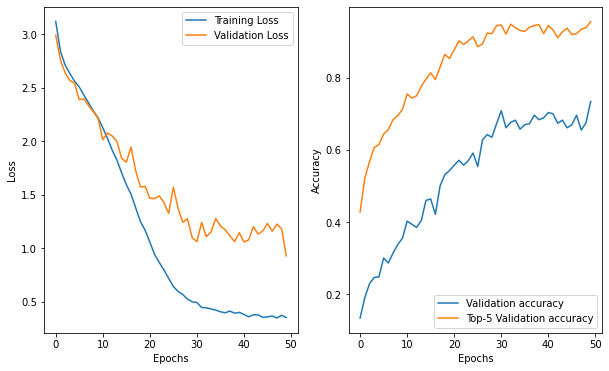

In [42]:
reload(utils.visualization)
visualization.plot_training_results(vit_rgb_imagenet_results, top_k=5)

### ViT only with RGB Images on EuroSat

In [25]:
# Create model
model_id = "philschmid/vit-base-patch16-224-in21k-euroSat"

vit_rgb_eurosat = vit(model_id, 
              input_shape=(256, 256, 3), 
              learning_rate=3e-4, 
              num_classes=NUM_CLASSES, 
              weight_decay_rate=0.0001
             )

vit_rgb_eurosat._name = 'vit-rgb-pretrained-euroSat'

Some layers from the model checkpoint at philschmid/vit-base-patch16-224-in21k-euroSat were not used when initializing TFViTModel: ['classifier', 'vit/encoder/layer_._6/attention/attention/key/bias:0', 'vit/encoder/layer_._9/intermediate/dense/bias:0', 'vit/encoder/layer_._11/layernorm_after/beta:0', 'vit/encoder/layer_._7/attention/attention/query/kernel:0', 'vit/encoder/layer_._9/output/dense/bias:0', 'vit/encoder/layer_._10/intermediate/dense/kernel:0', 'vit/encoder/layer_._9/attention/attention/key/kernel:0', 'vit/encoder/layer_._8/output/dense/kernel:0', 'vit/encoder/layer_._6/attention/output/dense/bias:0', 'vit/encoder/layer_._6/output/dense/kernel:0', 'vit/encoder/layer_._9/attention/output/dense/kernel:0', 'vit/encoder/layer_._9/intermediate/dense/kernel:0', 'vit/encoder/layer_._7/layernorm_after/gamma:0', 'vit/encoder/layer_._7/attention/attention/key/bias:0', 'vit/encoder/layer_._11/attention/attention/key/bias:0', 'vit/encoder/layer_._10/output/dense/kernel:0', 'vit/encoder

In [44]:
vit_rgb_eurosat_results = run_experiment(model=vit_rgb_eurosat,
                                 train_ds=train_ds,
                                 y_train=y_train,
                                 val_ds=val_ds,
                                 y_val=y_val,
                                 test_ds=test_ds,
                                 y_test=y_test,
                                 batch_size=batch_size,
                                 eval_batch_size=eval_batch_size,
                                 num_epochs=50,
                                 ds_reps_per_epoch=1,
                                )

Epoch 1/50


260/260 [==============================] - ETA: 0s - loss: 3.1493 - accuracy: 0.0917 - top-5-accuracy: 0.3504

INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


260/260 [==============================] - 206s 599ms/step - loss: 3.1493 - accuracy: 0.0917 - top-5-accuracy: 0.3504 - val_loss: 3.0215 - val_accuracy: 0.1200 - val_top-5-accuracy: 0.4137
Epoch 2/50
260/260 [==============================] - ETA: 0s - loss: 2.8811 - accuracy: 0.1561 - top-5-accuracy: 0.4785

INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


260/260 [==============================] - 146s 562ms/step - loss: 2.8811 - accuracy: 0.1561 - top-5-accuracy: 0.4785 - val_loss: 2.8105 - val_accuracy: 0.1762 - val_top-5-accuracy: 0.5213
Epoch 3/50
260/260 [==============================] - ETA: 0s - loss: 2.7498 - accuracy: 0.1930 - top-5-accuracy: 0.5299

INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


260/260 [==============================] - 148s 570ms/step - loss: 2.7498 - accuracy: 0.1930 - top-5-accuracy: 0.5299 - val_loss: 2.6627 - val_accuracy: 0.1937 - val_top-5-accuracy: 0.5700
Epoch 4/50
260/260 [==============================] - ETA: 0s - loss: 2.6648 - accuracy: 0.2162 - top-5-accuracy: 0.5623

INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


260/260 [==============================] - 146s 561ms/step - loss: 2.6648 - accuracy: 0.2162 - top-5-accuracy: 0.5623 - val_loss: 2.5764 - val_accuracy: 0.2212 - val_top-5-accuracy: 0.6212
Epoch 5/50
260/260 [==============================] - ETA: 0s - loss: 2.5974 - accuracy: 0.2357 - top-5-accuracy: 0.5829

INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


260/260 [==============================] - 149s 573ms/step - loss: 2.5974 - accuracy: 0.2357 - top-5-accuracy: 0.5829 - val_loss: 2.4837 - val_accuracy: 0.2512 - val_top-5-accuracy: 0.6225
Epoch 6/50
260/260 [==============================] - ETA: 0s - loss: 2.5361 - accuracy: 0.2507 - top-5-accuracy: 0.6026

INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


260/260 [==============================] - 146s 561ms/step - loss: 2.5361 - accuracy: 0.2507 - top-5-accuracy: 0.6026 - val_loss: 2.4183 - val_accuracy: 0.2862 - val_top-5-accuracy: 0.6388
Epoch 7/50
260/260 [==============================] - ETA: 0s - loss: 2.4873 - accuracy: 0.2608 - top-5-accuracy: 0.6196

INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


260/260 [==============================] - 146s 560ms/step - loss: 2.4873 - accuracy: 0.2608 - top-5-accuracy: 0.6196 - val_loss: 2.4002 - val_accuracy: 0.2713 - val_top-5-accuracy: 0.6550
Epoch 8/50
260/260 [==============================] - ETA: 0s - loss: 2.4281 - accuracy: 0.2788 - top-5-accuracy: 0.6376

INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


260/260 [==============================] - 150s 577ms/step - loss: 2.4281 - accuracy: 0.2788 - top-5-accuracy: 0.6376 - val_loss: 2.2763 - val_accuracy: 0.3088 - val_top-5-accuracy: 0.6900
Epoch 9/50
260/260 [==============================] - ETA: 0s - loss: 2.3637 - accuracy: 0.2926 - top-5-accuracy: 0.6604

INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


260/260 [==============================] - 146s 562ms/step - loss: 2.3637 - accuracy: 0.2926 - top-5-accuracy: 0.6604 - val_loss: 2.2515 - val_accuracy: 0.3050 - val_top-5-accuracy: 0.7000
Epoch 10/50
260/260 [==============================] - ETA: 0s - loss: 2.2920 - accuracy: 0.3165 - top-5-accuracy: 0.6814

INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


260/260 [==============================] - 150s 577ms/step - loss: 2.2920 - accuracy: 0.3165 - top-5-accuracy: 0.6814 - val_loss: 2.1832 - val_accuracy: 0.3462 - val_top-5-accuracy: 0.7038
Epoch 11/50
260/260 [==============================] - ETA: 0s - loss: 2.2343 - accuracy: 0.3321 - top-5-accuracy: 0.6958

INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


260/260 [==============================] - 146s 562ms/step - loss: 2.2343 - accuracy: 0.3321 - top-5-accuracy: 0.6958 - val_loss: 2.1320 - val_accuracy: 0.3425 - val_top-5-accuracy: 0.7163
Epoch 12/50
260/260 [==============================] - ETA: 0s - loss: 2.1562 - accuracy: 0.3520 - top-5-accuracy: 0.7208

INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


260/260 [==============================] - 149s 574ms/step - loss: 2.1562 - accuracy: 0.3520 - top-5-accuracy: 0.7208 - val_loss: 2.0630 - val_accuracy: 0.3675 - val_top-5-accuracy: 0.7513
Epoch 13/50
260/260 [==============================] - ETA: 0s - loss: 2.0777 - accuracy: 0.3727 - top-5-accuracy: 0.7403

INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


260/260 [==============================] - 146s 561ms/step - loss: 2.0777 - accuracy: 0.3727 - top-5-accuracy: 0.7403 - val_loss: 2.0022 - val_accuracy: 0.4025 - val_top-5-accuracy: 0.7575
Epoch 14/50
260/260 [==============================] - 122s 470ms/step - loss: 1.9859 - accuracy: 0.4018 - top-5-accuracy: 0.7605 - val_loss: 2.0170 - val_accuracy: 0.3913 - val_top-5-accuracy: 0.7437
Epoch 15/50
260/260 [==============================] - ETA: 0s - loss: 1.8998 - accuracy: 0.4274 - top-5-accuracy: 0.7834

INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


260/260 [==============================] - 148s 569ms/step - loss: 1.8998 - accuracy: 0.4274 - top-5-accuracy: 0.7834 - val_loss: 1.9202 - val_accuracy: 0.4187 - val_top-5-accuracy: 0.7937
Epoch 16/50
260/260 [==============================] - ETA: 0s - loss: 1.8213 - accuracy: 0.4456 - top-5-accuracy: 0.8015

INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


260/260 [==============================] - 146s 561ms/step - loss: 1.8213 - accuracy: 0.4456 - top-5-accuracy: 0.8015 - val_loss: 1.8277 - val_accuracy: 0.4375 - val_top-5-accuracy: 0.7875
Epoch 17/50
260/260 [==============================] - 123s 471ms/step - loss: 1.7134 - accuracy: 0.4799 - top-5-accuracy: 0.8240 - val_loss: 1.8729 - val_accuracy: 0.4338 - val_top-5-accuracy: 0.7887
Epoch 18/50
260/260 [==============================] - ETA: 0s - loss: 1.6426 - accuracy: 0.5002 - top-5-accuracy: 0.8387

INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


260/260 [==============================] - 146s 560ms/step - loss: 1.6426 - accuracy: 0.5002 - top-5-accuracy: 0.8387 - val_loss: 1.7064 - val_accuracy: 0.4800 - val_top-5-accuracy: 0.8363
Epoch 19/50
260/260 [==============================] - 122s 469ms/step - loss: 1.5670 - accuracy: 0.5217 - top-5-accuracy: 0.8531 - val_loss: 1.7938 - val_accuracy: 0.4538 - val_top-5-accuracy: 0.8200
Epoch 20/50
260/260 [==============================] - 122s 468ms/step - loss: 1.4639 - accuracy: 0.5499 - top-5-accuracy: 0.8718 - val_loss: 1.7157 - val_accuracy: 0.4787 - val_top-5-accuracy: 0.8462
Epoch 21/50
260/260 [==============================] - ETA: 0s - loss: 1.3728 - accuracy: 0.5746 - top-5-accuracy: 0.8898

INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


260/260 [==============================] - 149s 573ms/step - loss: 1.3728 - accuracy: 0.5746 - top-5-accuracy: 0.8898 - val_loss: 1.6473 - val_accuracy: 0.4900 - val_top-5-accuracy: 0.8550
Epoch 22/50
260/260 [==============================] - ETA: 0s - loss: 1.2406 - accuracy: 0.6145 - top-5-accuracy: 0.9100

INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


260/260 [==============================] - 146s 561ms/step - loss: 1.2406 - accuracy: 0.6145 - top-5-accuracy: 0.9100 - val_loss: 1.5987 - val_accuracy: 0.5312 - val_top-5-accuracy: 0.8550
Epoch 23/50
260/260 [==============================] - ETA: 0s - loss: 1.1722 - accuracy: 0.6362 - top-5-accuracy: 0.9198

INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


260/260 [==============================] - 149s 572ms/step - loss: 1.1722 - accuracy: 0.6362 - top-5-accuracy: 0.9198 - val_loss: 1.5359 - val_accuracy: 0.5337 - val_top-5-accuracy: 0.8625
Epoch 24/50
260/260 [==============================] - ETA: 0s - loss: 1.0941 - accuracy: 0.6592 - top-5-accuracy: 0.9320

INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


260/260 [==============================] - 146s 562ms/step - loss: 1.0941 - accuracy: 0.6592 - top-5-accuracy: 0.9320 - val_loss: 1.4110 - val_accuracy: 0.5738 - val_top-5-accuracy: 0.8700
Epoch 25/50
260/260 [==============================] - 123s 471ms/step - loss: 1.0093 - accuracy: 0.6840 - top-5-accuracy: 0.9433 - val_loss: 1.5242 - val_accuracy: 0.5562 - val_top-5-accuracy: 0.8650
Epoch 26/50
260/260 [==============================] - ETA: 0s - loss: 0.9457 - accuracy: 0.7051 - top-5-accuracy: 0.9513

INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


260/260 [==============================] - 149s 572ms/step - loss: 0.9457 - accuracy: 0.7051 - top-5-accuracy: 0.9513 - val_loss: 1.3789 - val_accuracy: 0.6137 - val_top-5-accuracy: 0.8888
Epoch 27/50
260/260 [==============================] - 123s 471ms/step - loss: 0.8824 - accuracy: 0.7218 - top-5-accuracy: 0.9574 - val_loss: 1.4169 - val_accuracy: 0.5612 - val_top-5-accuracy: 0.8900
Epoch 28/50
260/260 [==============================] - 122s 468ms/step - loss: 0.8334 - accuracy: 0.7369 - top-5-accuracy: 0.9644 - val_loss: 1.5473 - val_accuracy: 0.5500 - val_top-5-accuracy: 0.8900
Epoch 29/50
260/260 [==============================] - 122s 470ms/step - loss: 0.7757 - accuracy: 0.7544 - top-5-accuracy: 0.9686 - val_loss: 1.4001 - val_accuracy: 0.5738 - val_top-5-accuracy: 0.9087
Epoch 30/50
260/260 [==============================] - ETA: 0s - loss: 0.7136 - accuracy: 0.7736 - top-5-accuracy: 0.9731

INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


260/260 [==============================] - 145s 558ms/step - loss: 0.7136 - accuracy: 0.7736 - top-5-accuracy: 0.9731 - val_loss: 1.2284 - val_accuracy: 0.6313 - val_top-5-accuracy: 0.9187
Epoch 31/50
260/260 [==============================] - ETA: 0s - loss: 0.6807 - accuracy: 0.7858 - top-5-accuracy: 0.9769

INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


260/260 [==============================] - 149s 572ms/step - loss: 0.6807 - accuracy: 0.7858 - top-5-accuracy: 0.9769 - val_loss: 1.1432 - val_accuracy: 0.6625 - val_top-5-accuracy: 0.9200
Epoch 32/50
260/260 [==============================] - 123s 472ms/step - loss: 0.6255 - accuracy: 0.8005 - top-5-accuracy: 0.9816 - val_loss: 1.1614 - val_accuracy: 0.6637 - val_top-5-accuracy: 0.9312
Epoch 33/50
260/260 [==============================] - 122s 471ms/step - loss: 0.6006 - accuracy: 0.8111 - top-5-accuracy: 0.9816 - val_loss: 1.1840 - val_accuracy: 0.6463 - val_top-5-accuracy: 0.9350
Epoch 34/50
260/260 [==============================] - 123s 472ms/step - loss: 0.5784 - accuracy: 0.8177 - top-5-accuracy: 0.9825 - val_loss: 1.2814 - val_accuracy: 0.6463 - val_top-5-accuracy: 0.9225
Epoch 35/50
260/260 [==============================] - 123s 471ms/step - loss: 0.5440 - accuracy: 0.8279 - top-5-accuracy: 0.9847 - val_loss: 1.1476 - val_accuracy: 0.6637 - val_top-5-accuracy: 0.9350
Epoch 3

INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


260/260 [==============================] - 146s 561ms/step - loss: 0.5104 - accuracy: 0.8372 - top-5-accuracy: 0.9873 - val_loss: 1.0140 - val_accuracy: 0.6888 - val_top-5-accuracy: 0.9475
Epoch 38/50
260/260 [==============================] - 122s 468ms/step - loss: 0.5051 - accuracy: 0.8384 - top-5-accuracy: 0.9871 - val_loss: 1.2843 - val_accuracy: 0.6313 - val_top-5-accuracy: 0.9200
Epoch 39/50
260/260 [==============================] - 122s 470ms/step - loss: 0.4995 - accuracy: 0.8396 - top-5-accuracy: 0.9875 - val_loss: 1.1605 - val_accuracy: 0.6538 - val_top-5-accuracy: 0.9337
Epoch 40/50
260/260 [==============================] - 122s 470ms/step - loss: 0.4732 - accuracy: 0.8490 - top-5-accuracy: 0.9883 - val_loss: 1.0149 - val_accuracy: 0.6938 - val_top-5-accuracy: 0.9538
Epoch 41/50
260/260 [==============================] - 122s 469ms/step - loss: 0.4555 - accuracy: 0.8554 - top-5-accuracy: 0.9899 - val_loss: 1.2979 - val_accuracy: 0.6237 - val_top-5-accuracy: 0.9275
Epoch 4

INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-rgb-pretrained-euroSat/assets


260/260 [==============================] - 146s 561ms/step - loss: 0.4311 - accuracy: 0.8588 - top-5-accuracy: 0.9906 - val_loss: 0.9564 - val_accuracy: 0.7225 - val_top-5-accuracy: 0.9538
Epoch 48/50
260/260 [==============================] - 122s 468ms/step - loss: 0.4284 - accuracy: 0.8622 - top-5-accuracy: 0.9900 - val_loss: 1.2478 - val_accuracy: 0.6513 - val_top-5-accuracy: 0.9250
Epoch 49/50
260/260 [==============================] - 121s 467ms/step - loss: 0.4308 - accuracy: 0.8635 - top-5-accuracy: 0.9909 - val_loss: 1.1487 - val_accuracy: 0.6488 - val_top-5-accuracy: 0.9287
Epoch 50/50
217/229 [===========================>..] - ETA: 0s - loss: 6.7782 - accuracy: 0.0841 - top-5-accuracy: 0.2751WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 229.0 batches). You may need to use the repeat() function when building your dataset.


229/229 [==============================] - 9s 40ms/step - loss: 6.7923 - accuracy: 0.0837 - top-5-accuracy: 0.2741
Test accuracy: 8.37%
Test top 5 accuracy: 27.41%


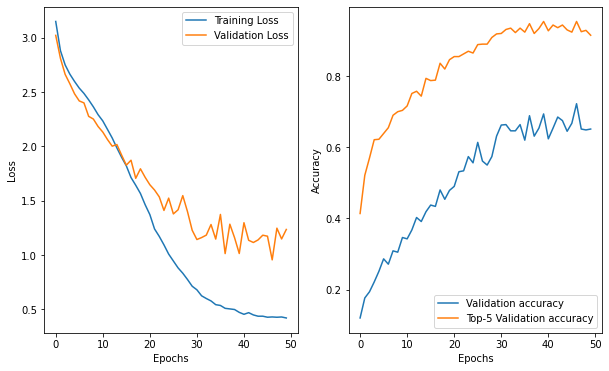

In [45]:
visualization.plot_training_results(vit_rgb_eurosat_results)

In [46]:
vit_rgb_eurosat.summary()

Model: "vit-rgb-pretrained-euroSat"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rgb_input (InputLayer)      [(None, 256, 256, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 3, 224, 224)      0         
 al)                                                             
                                                                 
 tf_vi_t_model_2 (TFViTModel  TFBaseModelOutputWithPoo  43862016 
 )                           ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                        

### ViT with all Satellite Image Data

In [47]:
# generate data using all types of data for an observation
train_data = custom_generators.FullSatelliteGenerator(train_ids, y_train, batch_size, DATA_PATH)
val_data = custom_generators.FullSatelliteGenerator(val_ids, y_val, eval_batch_size, DATA_PATH)
test_data = custom_generators.FullSatelliteGenerator(test_ids, y_test, eval_batch_size, DATA_PATH)
tf_train_dataset = tf.data.Dataset.from_generator(lambda: train_data, output_types = (tf.float16 , tf.float16))
tf_val_dataset = tf.data.Dataset.from_generator(lambda: val_data, output_types = (tf.float16 , tf.float16))
tf_test_dataset = tf.data.Dataset.from_generator(lambda: test_data, output_types = (tf.float16 , tf.float16))
train_ds = tf_train_dataset.with_options(options)
val_ds = tf_val_dataset.with_options(options)
test_ds = tf_test_dataset.with_options(options)

In [48]:
model_id = "philschmid/vit-base-patch16-224-in21k-euroSat"

vit_sat = vit(model_id, 
                      input_shape=(256, 256, 3), 
                      learning_rate=3e-4, 
                      num_classes=NUM_CLASSES, 
                      weight_decay_rate=0.0001
                     )

vit_sat._name = 'vit-all-sat-pretrained-euroSat'

vit_sat_results = run_experiment(model=vit_sat,
                                 train_ds=train_ds,
                                 y_train=y_train,
                                 val_ds=val_ds,
                                 y_val=y_val,
                                 test_ds=test_ds,
                                 y_test=y_test,
                                 batch_size=batch_size,
                                 eval_batch_size=eval_batch_size,
                                 num_epochs=50,
                                 ds_reps_per_epoch=1,
                                )

Some layers from the model checkpoint at philschmid/vit-base-patch16-224-in21k-euroSat were not used when initializing TFViTModel: ['classifier', 'vit/encoder/layer_._10/intermediate/dense/bias:0', 'vit/encoder/layer_._7/attention/attention/value/kernel:0', 'vit/encoder/layer_._10/attention/output/dense/kernel:0', 'vit/encoder/layer_._10/output/dense/bias:0', 'vit/encoder/layer_._8/attention/attention/value/kernel:0', 'vit/encoder/layer_._10/layernorm_after/beta:0', 'vit/encoder/layer_._9/attention/attention/query/kernel:0', 'vit/encoder/layer_._11/intermediate/dense/bias:0', 'vit/encoder/layer_._6/intermediate/dense/bias:0', 'vit/encoder/layer_._7/intermediate/dense/bias:0', 'vit/encoder/layer_._9/layernorm_after/beta:0', 'vit/encoder/layer_._10/layernorm_before/beta:0', 'vit/encoder/layer_._6/attention/output/dense/bias:0', 'vit/encoder/layer_._8/output/dense/bias:0', 'vit/encoder/layer_._8/output/dense/kernel:0', 'vit/encoder/layer_._9/layernorm_before/beta:0', 'vit/encoder/layer_._

Epoch 1/50


260/260 [==============================] - ETA: 0s - loss: 3.3047 - accuracy: 0.0664 - top-5-accuracy: 0.2720

INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


260/260 [==============================] - 203s 599ms/step - loss: 3.3047 - accuracy: 0.0664 - top-5-accuracy: 0.2720 - val_loss: 3.1128 - val_accuracy: 0.1350 - val_top-5-accuracy: 0.3975
Epoch 2/50
260/260 [==============================] - ETA: 0s - loss: 3.1577 - accuracy: 0.0956 - top-5-accuracy: 0.3474

INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


260/260 [==============================] - 144s 556ms/step - loss: 3.1577 - accuracy: 0.0956 - top-5-accuracy: 0.3474 - val_loss: 3.1127 - val_accuracy: 0.1600 - val_top-5-accuracy: 0.3787
Epoch 3/50
260/260 [==============================] - ETA: 0s - loss: 3.0990 - accuracy: 0.1114 - top-5-accuracy: 0.3752

INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


260/260 [==============================] - 148s 570ms/step - loss: 3.0990 - accuracy: 0.1114 - top-5-accuracy: 0.3752 - val_loss: 3.0408 - val_accuracy: 0.1575 - val_top-5-accuracy: 0.3950
Epoch 4/50
260/260 [==============================] - ETA: 0s - loss: 3.0312 - accuracy: 0.1308 - top-5-accuracy: 0.4132

INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


260/260 [==============================] - 146s 561ms/step - loss: 3.0312 - accuracy: 0.1308 - top-5-accuracy: 0.4132 - val_loss: 2.9395 - val_accuracy: 0.1937 - val_top-5-accuracy: 0.4700
Epoch 5/50
260/260 [==============================] - ETA: 0s - loss: 2.9772 - accuracy: 0.1441 - top-5-accuracy: 0.4374

INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


260/260 [==============================] - 145s 556ms/step - loss: 2.9772 - accuracy: 0.1441 - top-5-accuracy: 0.4374 - val_loss: 2.9315 - val_accuracy: 0.1775 - val_top-5-accuracy: 0.4863
Epoch 6/50
260/260 [==============================] - ETA: 0s - loss: 2.9372 - accuracy: 0.1552 - top-5-accuracy: 0.4571

INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


260/260 [==============================] - 148s 571ms/step - loss: 2.9372 - accuracy: 0.1552 - top-5-accuracy: 0.4571 - val_loss: 2.8863 - val_accuracy: 0.1912 - val_top-5-accuracy: 0.5050
Epoch 7/50
260/260 [==============================] - 122s 468ms/step - loss: 2.9068 - accuracy: 0.1599 - top-5-accuracy: 0.4707 - val_loss: 2.9111 - val_accuracy: 0.1725 - val_top-5-accuracy: 0.4963
Epoch 8/50
260/260 [==============================] - 121s 466ms/step - loss: 2.8822 - accuracy: 0.1657 - top-5-accuracy: 0.4803 - val_loss: 2.9187 - val_accuracy: 0.1688 - val_top-5-accuracy: 0.5013
Epoch 9/50
260/260 [==============================] - ETA: 0s - loss: 2.8597 - accuracy: 0.1720 - top-5-accuracy: 0.4874

INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


260/260 [==============================] - 145s 557ms/step - loss: 2.8597 - accuracy: 0.1720 - top-5-accuracy: 0.4874 - val_loss: 2.8852 - val_accuracy: 0.1825 - val_top-5-accuracy: 0.5088
Epoch 10/50
260/260 [==============================] - 122s 470ms/step - loss: 2.8304 - accuracy: 0.1811 - top-5-accuracy: 0.5031 - val_loss: 2.9597 - val_accuracy: 0.1813 - val_top-5-accuracy: 0.4638
Epoch 11/50
260/260 [==============================] - ETA: 0s - loss: 2.8027 - accuracy: 0.1879 - top-5-accuracy: 0.5097

INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


260/260 [==============================] - 148s 570ms/step - loss: 2.8027 - accuracy: 0.1879 - top-5-accuracy: 0.5097 - val_loss: 2.8668 - val_accuracy: 0.2013 - val_top-5-accuracy: 0.5063
Epoch 12/50
260/260 [==============================] - 121s 466ms/step - loss: 2.7914 - accuracy: 0.1924 - top-5-accuracy: 0.5141 - val_loss: 2.9620 - val_accuracy: 0.1825 - val_top-5-accuracy: 0.4900
Epoch 13/50
260/260 [==============================] - 122s 468ms/step - loss: 2.7709 - accuracy: 0.1953 - top-5-accuracy: 0.5260 - val_loss: 2.9440 - val_accuracy: 0.1737 - val_top-5-accuracy: 0.4875
Epoch 14/50
260/260 [==============================] - 122s 469ms/step - loss: 2.7481 - accuracy: 0.2018 - top-5-accuracy: 0.5300 - val_loss: 2.8970 - val_accuracy: 0.1900 - val_top-5-accuracy: 0.4988
Epoch 15/50
260/260 [==============================] - 121s 467ms/step - loss: 2.7267 - accuracy: 0.2068 - top-5-accuracy: 0.5402 - val_loss: 3.0074 - val_accuracy: 0.1600 - val_top-5-accuracy: 0.4712
Epoch 1

INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


260/260 [==============================] - 145s 556ms/step - loss: 2.6742 - accuracy: 0.2163 - top-5-accuracy: 0.5567 - val_loss: 2.8443 - val_accuracy: 0.1900 - val_top-5-accuracy: 0.5325
Epoch 18/50
260/260 [==============================] - 122s 468ms/step - loss: 2.6524 - accuracy: 0.2258 - top-5-accuracy: 0.5667 - val_loss: 2.9807 - val_accuracy: 0.1663 - val_top-5-accuracy: 0.5013
Epoch 19/50
260/260 [==============================] - 121s 466ms/step - loss: 2.6244 - accuracy: 0.2319 - top-5-accuracy: 0.5727 - val_loss: 2.9465 - val_accuracy: 0.1713 - val_top-5-accuracy: 0.5025
Epoch 20/50
260/260 [==============================] - 121s 465ms/step - loss: 2.6060 - accuracy: 0.2378 - top-5-accuracy: 0.5838 - val_loss: 2.8901 - val_accuracy: 0.1900 - val_top-5-accuracy: 0.4975
Epoch 21/50
260/260 [==============================] - 121s 467ms/step - loss: 2.5721 - accuracy: 0.2467 - top-5-accuracy: 0.5922 - val_loss: 2.9628 - val_accuracy: 0.1937 - val_top-5-accuracy: 0.4988
Epoch 2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



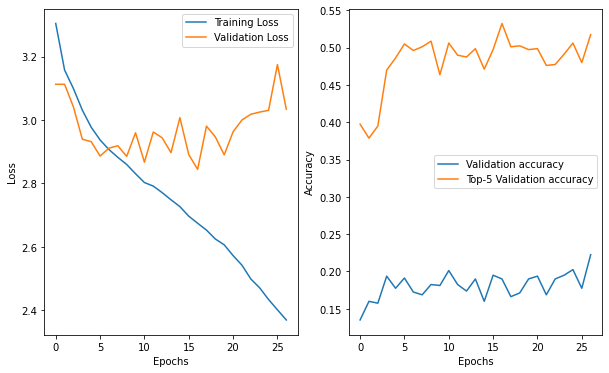

In [49]:
visualization.plot_training_results(vit_sat_results)

In [50]:
vit_sat.summary()

Model: "vit-all-sat-pretrained-euroSat"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rgb_input (InputLayer)      [(None, 256, 256, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 3, 224, 224)      0         
 al)                                                             
                                                                 
 tf_vi_t_model_3 (TFViTModel  TFBaseModelOutputWithPoo  43862016 
 )                           ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                    

### ViT all Sat EuroSat Channels=6

In [51]:
# generate data using all types of data for an observation
train_data = custom_generators.FullSatelliteGeneratorChannels(train_ids, y_train, batch_size, DATA_PATH)
val_data = custom_generators.FullSatelliteGeneratorChannels(val_ids, y_val, eval_batch_size, DATA_PATH)
test_data = custom_generators.FullSatelliteGeneratorChannels(test_ids, y_test, eval_batch_size, DATA_PATH)
tf_train_dataset = tf.data.Dataset.from_generator(lambda: train_data, output_types = (tf.float16 , tf.float16))
tf_val_dataset = tf.data.Dataset.from_generator(lambda: val_data, output_types = (tf.float16 , tf.float16))
tf_test_dataset = tf.data.Dataset.from_generator(lambda: test_data, output_types = (tf.float16 , tf.float16))
train_ds = tf_train_dataset.with_options(options)
val_ds = tf_val_dataset.with_options(options)
test_ds = tf_test_dataset.with_options(options)

In [52]:
model_id = "philschmid/vit-base-patch16-224-in21k-euroSat"

vit_sat_ch = vit(model_id, 
              input_shape=(256, 256, 3), 
              learning_rate=3e-4, 
              num_classes=NUM_CLASSES, 
              weight_decay_rate=0.0001,
              num_channels=6
             )

vit_sat_ch._name = 'vit-all-sat-pretrained-euroSat'

vit_sat_ch_results = run_experiment(model=vit_sat,
                                 train_ds=train_ds,
                                 y_train=y_train,
                                 val_ds=val_ds,
                                 y_val=y_val,
                                 test_ds=test_ds,
                                 y_test=y_test,
                                 batch_size=batch_size,
                                 eval_batch_size=eval_batch_size,
                                 num_epochs=50,
                                 ds_reps_per_epoch=1,
                                )

Some layers from the model checkpoint at philschmid/vit-base-patch16-224-in21k-euroSat were not used when initializing TFViTModel: ['classifier', 'vit/encoder/layer_._10/intermediate/dense/bias:0', 'vit/encoder/layer_._7/attention/attention/value/kernel:0', 'vit/encoder/layer_._10/attention/output/dense/kernel:0', 'vit/encoder/layer_._10/output/dense/bias:0', 'vit/encoder/layer_._8/attention/attention/value/kernel:0', 'vit/encoder/layer_._10/layernorm_after/beta:0', 'vit/encoder/layer_._9/attention/attention/query/kernel:0', 'vit/encoder/layer_._11/intermediate/dense/bias:0', 'vit/encoder/layer_._6/intermediate/dense/bias:0', 'vit/encoder/layer_._7/intermediate/dense/bias:0', 'vit/encoder/layer_._9/layernorm_after/beta:0', 'vit/encoder/layer_._10/layernorm_before/beta:0', 'vit/encoder/layer_._6/attention/output/dense/bias:0', 'vit/encoder/layer_._8/output/dense/bias:0', 'vit/encoder/layer_._8/output/dense/kernel:0', 'vit/encoder/layer_._9/layernorm_before/beta:0', 'vit/encoder/layer_._

Epoch 1/50
260/260 [==============================] - ETA: 0s - loss: 2.8221 - accuracy: 0.1837 - top-5-accuracy: 0.5060

INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


260/260 [==============================] - 245s 934ms/step - loss: 2.8221 - accuracy: 0.1837 - top-5-accuracy: 0.5060 - val_loss: 2.7819 - val_accuracy: 0.1988 - val_top-5-accuracy: 0.5288
Epoch 2/50
260/260 [==============================] - ETA: 0s - loss: 2.7205 - accuracy: 0.2082 - top-5-accuracy: 0.5443

INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


260/260 [==============================] - 244s 940ms/step - loss: 2.7205 - accuracy: 0.2082 - top-5-accuracy: 0.5443 - val_loss: 2.7519 - val_accuracy: 0.2037 - val_top-5-accuracy: 0.5437
Epoch 3/50
260/260 [==============================] - ETA: 0s - loss: 2.6784 - accuracy: 0.2176 - top-5-accuracy: 0.5570

INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


260/260 [==============================] - 240s 926ms/step - loss: 2.6784 - accuracy: 0.2176 - top-5-accuracy: 0.5570 - val_loss: 2.6660 - val_accuracy: 0.2212 - val_top-5-accuracy: 0.5650
Epoch 4/50
260/260 [==============================] - ETA: 0s - loss: 2.6429 - accuracy: 0.2283 - top-5-accuracy: 0.5691

INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


260/260 [==============================] - 240s 924ms/step - loss: 2.6429 - accuracy: 0.2283 - top-5-accuracy: 0.5691 - val_loss: 2.6128 - val_accuracy: 0.2338 - val_top-5-accuracy: 0.6100
Epoch 5/50
260/260 [==============================] - ETA: 0s - loss: 2.6245 - accuracy: 0.2317 - top-5-accuracy: 0.5772

INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


260/260 [==============================] - 243s 936ms/step - loss: 2.6245 - accuracy: 0.2317 - top-5-accuracy: 0.5772 - val_loss: 2.5823 - val_accuracy: 0.2438 - val_top-5-accuracy: 0.6012
Epoch 6/50
260/260 [==============================] - ETA: 0s - loss: 2.5874 - accuracy: 0.2395 - top-5-accuracy: 0.5888

INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


260/260 [==============================] - 239s 918ms/step - loss: 2.5874 - accuracy: 0.2395 - top-5-accuracy: 0.5888 - val_loss: 2.5789 - val_accuracy: 0.2537 - val_top-5-accuracy: 0.6100
Epoch 7/50
260/260 [==============================] - 217s 834ms/step - loss: 2.5701 - accuracy: 0.2468 - top-5-accuracy: 0.5925 - val_loss: 2.6014 - val_accuracy: 0.2288 - val_top-5-accuracy: 0.6050
Epoch 8/50
260/260 [==============================] - 216s 833ms/step - loss: 2.5502 - accuracy: 0.2508 - top-5-accuracy: 0.6018 - val_loss: 2.5826 - val_accuracy: 0.2562 - val_top-5-accuracy: 0.6212
Epoch 9/50
260/260 [==============================] - ETA: 0s - loss: 2.5321 - accuracy: 0.2549 - top-5-accuracy: 0.6050

INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


260/260 [==============================] - 244s 939ms/step - loss: 2.5321 - accuracy: 0.2549 - top-5-accuracy: 0.6050 - val_loss: 2.5495 - val_accuracy: 0.2625 - val_top-5-accuracy: 0.6112
Epoch 10/50
260/260 [==============================] - ETA: 0s - loss: 2.4954 - accuracy: 0.2657 - top-5-accuracy: 0.6190

INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


260/260 [==============================] - 239s 920ms/step - loss: 2.4954 - accuracy: 0.2657 - top-5-accuracy: 0.6190 - val_loss: 2.5295 - val_accuracy: 0.2650 - val_top-5-accuracy: 0.6200
Epoch 11/50
260/260 [==============================] - 216s 832ms/step - loss: 2.4733 - accuracy: 0.2687 - top-5-accuracy: 0.6291 - val_loss: 2.5439 - val_accuracy: 0.2550 - val_top-5-accuracy: 0.6075
Epoch 12/50
260/260 [==============================] - ETA: 0s - loss: 2.4527 - accuracy: 0.2723 - top-5-accuracy: 0.6330

INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


260/260 [==============================] - 240s 925ms/step - loss: 2.4527 - accuracy: 0.2723 - top-5-accuracy: 0.6330 - val_loss: 2.5035 - val_accuracy: 0.2650 - val_top-5-accuracy: 0.6225
Epoch 13/50
260/260 [==============================] - ETA: 0s - loss: 2.4277 - accuracy: 0.2810 - top-5-accuracy: 0.6427

INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


260/260 [==============================] - 243s 937ms/step - loss: 2.4277 - accuracy: 0.2810 - top-5-accuracy: 0.6427 - val_loss: 2.4844 - val_accuracy: 0.2825 - val_top-5-accuracy: 0.6075
Epoch 14/50
260/260 [==============================] - 216s 831ms/step - loss: 2.3897 - accuracy: 0.2906 - top-5-accuracy: 0.6553 - val_loss: 2.5244 - val_accuracy: 0.2587 - val_top-5-accuracy: 0.6212
Epoch 15/50
260/260 [==============================] - 215s 829ms/step - loss: 2.3627 - accuracy: 0.2993 - top-5-accuracy: 0.6603 - val_loss: 2.5439 - val_accuracy: 0.2825 - val_top-5-accuracy: 0.6050
Epoch 16/50
260/260 [==============================] - ETA: 0s - loss: 2.3297 - accuracy: 0.3084 - top-5-accuracy: 0.6730

INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


260/260 [==============================] - 239s 921ms/step - loss: 2.3297 - accuracy: 0.3084 - top-5-accuracy: 0.6730 - val_loss: 2.4789 - val_accuracy: 0.2575 - val_top-5-accuracy: 0.6450
Epoch 17/50
260/260 [==============================] - 217s 835ms/step - loss: 2.2920 - accuracy: 0.3167 - top-5-accuracy: 0.6844 - val_loss: 2.5074 - val_accuracy: 0.2800 - val_top-5-accuracy: 0.6325
Epoch 18/50
260/260 [==============================] - ETA: 0s - loss: 2.2409 - accuracy: 0.3307 - top-5-accuracy: 0.7005

INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


260/260 [==============================] - 242s 931ms/step - loss: 2.2409 - accuracy: 0.3307 - top-5-accuracy: 0.7005 - val_loss: 2.4399 - val_accuracy: 0.2925 - val_top-5-accuracy: 0.6575
Epoch 19/50
260/260 [==============================] - 216s 832ms/step - loss: 2.2032 - accuracy: 0.3419 - top-5-accuracy: 0.7119 - val_loss: 2.4875 - val_accuracy: 0.2688 - val_top-5-accuracy: 0.6513
Epoch 20/50
260/260 [==============================] - ETA: 0s - loss: 2.1778 - accuracy: 0.3481 - top-5-accuracy: 0.7189

INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


260/260 [==============================] - 239s 921ms/step - loss: 2.1778 - accuracy: 0.3481 - top-5-accuracy: 0.7189 - val_loss: 2.4133 - val_accuracy: 0.2800 - val_top-5-accuracy: 0.6650
Epoch 21/50
260/260 [==============================] - 217s 836ms/step - loss: 2.1239 - accuracy: 0.3639 - top-5-accuracy: 0.7337 - val_loss: 2.5831 - val_accuracy: 0.2525 - val_top-5-accuracy: 0.6275
Epoch 22/50
260/260 [==============================] - 216s 830ms/step - loss: 2.0663 - accuracy: 0.3802 - top-5-accuracy: 0.7468 - val_loss: 2.5100 - val_accuracy: 0.2812 - val_top-5-accuracy: 0.6338
Epoch 23/50
260/260 [==============================] - 216s 831ms/step - loss: 2.0065 - accuracy: 0.3953 - top-5-accuracy: 0.7647 - val_loss: 2.5007 - val_accuracy: 0.2788 - val_top-5-accuracy: 0.6363
Epoch 24/50
260/260 [==============================] - 216s 832ms/step - loss: 1.9296 - accuracy: 0.4193 - top-5-accuracy: 0.7809 - val_loss: 2.6583 - val_accuracy: 0.2887 - val_top-5-accuracy: 0.6413
Epoch 2

INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


260/260 [==============================] - 243s 935ms/step - loss: 1.8471 - accuracy: 0.4403 - top-5-accuracy: 0.8021 - val_loss: 2.3782 - val_accuracy: 0.3212 - val_top-5-accuracy: 0.6925
Epoch 27/50
260/260 [==============================] - 218s 840ms/step - loss: 1.7501 - accuracy: 0.4678 - top-5-accuracy: 0.8197 - val_loss: 2.6012 - val_accuracy: 0.3025 - val_top-5-accuracy: 0.6525
Epoch 28/50
260/260 [==============================] - ETA: 0s - loss: 1.6915 - accuracy: 0.4876 - top-5-accuracy: 0.8331

INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


INFO:tensorflow:Assets written to: models/vit-all-sat-pretrained-euroSat/assets


260/260 [==============================] - 241s 927ms/step - loss: 1.6915 - accuracy: 0.4876 - top-5-accuracy: 0.8331 - val_loss: 2.2581 - val_accuracy: 0.3525 - val_top-5-accuracy: 0.7188
Epoch 29/50
260/260 [==============================] - 217s 835ms/step - loss: 1.6429 - accuracy: 0.4999 - top-5-accuracy: 0.8434 - val_loss: 2.3074 - val_accuracy: 0.3663 - val_top-5-accuracy: 0.7150
Epoch 30/50
260/260 [==============================] - 218s 838ms/step - loss: 1.5538 - accuracy: 0.5255 - top-5-accuracy: 0.8574 - val_loss: 2.3831 - val_accuracy: 0.3475 - val_top-5-accuracy: 0.7125
Epoch 31/50
260/260 [==============================] - 216s 830ms/step - loss: 1.4859 - accuracy: 0.5473 - top-5-accuracy: 0.8687 - val_loss: 2.4366 - val_accuracy: 0.3262 - val_top-5-accuracy: 0.7038
Epoch 32/50
260/260 [==============================] - 215s 829ms/step - loss: 1.4243 - accuracy: 0.5600 - top-5-accuracy: 0.8798 - val_loss: 2.6385 - val_accuracy: 0.3275 - val_top-5-accuracy: 0.6850
Epoch 3

229/229 [==============================] - 22s 95ms/step - loss: 4.9568 - accuracy: 0.0820 - top-5-accuracy: 0.2850
Test accuracy: 8.2%
Test top 5 accuracy: 28.5%


In [ ]:
visualization.plot_training_results(vit_sat_ch_results)

In [54]:
vit_sat_ch.summary()

Model: "vit-all-sat-pretrained-euroSat"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rgb_input (InputLayer)      [(None, 256, 256, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 3, 224, 224)      0         
 al)                                                             
                                                                 
 tf_vi_t_model_4 (TFViTModel  TFBaseModelOutputWithPoo  43862016 
 )                           ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                    

# Multimodal ViT From Scratch

In [26]:
learning_rate = 0.0001
weight_decay = 0.001
batch_size = 32
eval_batch_size = 8
num_epochs = 50
image_size = 144  # We'll resize input images to this size (smaller than in other ViT to prevent overfitting)
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
input_shape = (256, 256, 3)
num_cols = input_cells.shape[1]
projection_dim = 64
num_heads = 6
num_classes = NUM_CLASSES
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 6
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [27]:
# Patch creation
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_size": self.patch_size,
        })
        return config
    
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
    
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.type_embedding = layers.Embedding(
            input_dim=num_cols, output_dim=projection_dim
        )
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection": self.projection,
            "position_embedding": self.position_embedding,
            "type_embedding": self.type_embedding,
        })
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        type_token = 0 # add type token for image
        encoded = self.projection(patch) + self.position_embedding(positions) + self.type_embedding(type_token)
        return encoded
    
class NumericEncoder(layers.Layer):
    def __init__(self, num_cols, projection_dim):
        super(NumericEncoder, self).__init__()
        self.num_cols = num_cols
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_cols, output_dim=projection_dim
        )
        self.type_embedding = layers.Embedding(
            input_dim=num_cols, output_dim=projection_dim
        )
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_cols": self.num_cols,
            "projection": self.projection,
            "position_embedding": self.position_embedding,
            "type_embedding": self.type_embedding,
        })
        return config

    def call(self, cell):
        positions = tf.range(start=0, limit=self.num_cols, delta=1)
        type_token = 1 # add type token for numeric
        encoded = self.projection(cell) + self.position_embedding(positions) + self.type_embedding(type_token)
        return encoded

In [28]:
# # Visualize patches
# plt.figure(figsize=(4, 4))
# image = np.asarray(load_patch(train_ids[10], DATA_PATH, data='rgb')).reshape(256, 256, 3)
# plt.imshow(image.astype("uint8"))
# plt.axis("off")

# resized_image = tf.image.resize(
#     tf.convert_to_tensor([image]), size=(image_size, image_size)
# )
# patches = Patches(patch_size)(resized_image)
# print(f"Image size: {image_size} X {image_size}")
# print(f"Patch size: {patch_size} X {patch_size}")
# print(f"Patches per image: {patches.shape[1]}")
# print(f"Elements per patch: {patches.shape[-1]}")

# n = int(np.sqrt(patches.shape[1]))
# plt.figure(figsize=(4, 4))
# for i, patch in enumerate(patches[0]):
#     ax = plt.subplot(n, n, i + 1)
#     patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
#     plt.imshow(patch_img.numpy().astype("uint8"))
#     plt.axis("off")

In [29]:
def create_vit_classifier():
    with mirrored_strategy.scope():
        input_patches = layers.Input(shape=input_shape, name='input_1')
        input_cells = layers.Input(shape=(num_cols, 1), name='input_2')
         # Augment data.
        augmented = data_augmentation_cnn(output_size=image_size)(input_patches)
        # Create patches.
        patches = Patches(patch_size)(augmented)
        # Encode patches.
        encoded_patches = PatchEncoder(num_patches, projection_dim)(patches) # Output = (Number of patches, projection dimension)
        # Encode columns
        encoded_cells = NumericEncoder(num_cols, projection_dim)(input_cells) # Output = (Number of columns, projection dimension)

        # Concatenate patches and column embeddings with <SEP> token
        embeddings = layers.Concatenate(axis=1)([encoded_patches, encoded_cells]) # Output (#patches + #columns, projection dimension)    

        # Create multiple layers of the Transformer block.
        for _ in range(transformer_layers):
            # Layer normalization 1.
            x1 = layers.LayerNormalization(epsilon=1e-6)(embeddings)
            # Create a multi-head attention layer.
            attention_output = layers.MultiHeadAttention(
                num_heads=num_heads, key_dim=projection_dim, dropout=0.1
            )(x1, x1)
            # Skip connection 1.
            x2 = layers.Add()([attention_output, embeddings])
            # Layer normalization 2.
            x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
            # MLP.
            x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
            # Skip connection 2.
            embeddings = layers.Add()([x3, x2])

        # Create a [batch_size, projection_dim] tensor.
        representation = layers.LayerNormalization(epsilon=1e-6)(embeddings)
        representation = layers.Flatten()(representation)
        representation = layers.Dropout(0.5)(representation)

        # Add MLP.
        features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

        # Classify outputs.
        logits = layers.Dense(num_classes)(features)
        # Create the Keras model.
        model = keras.Model(inputs=[input_patches, input_cells], outputs=logits)
        
        optimizer = tfa.optimizers.AdamW(
            learning_rate=learning_rate, weight_decay=weight_decay
        )

        model.compile(
            optimizer=optimizer,
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[
                keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
            ],
        )
    
        return model

In [30]:
multimodal_vit = create_vit_classifier()

In [31]:
# multimodal_vit.summary()

In [32]:
reload(utils.custom_generators)
train_data = custom_generators.MultimodalTransformerGenerator(train_ids, y_train, batch_size, DATA_PATH, input_cells)
val_data = custom_generators.MultimodalTransformerGenerator(val_ids, y_val, eval_batch_size, DATA_PATH, val_cells)
test_data = custom_generators.MultimodalTransformerGenerator(test_ids, y_test, eval_batch_size, DATA_PATH, test_cells)

# converting our train dataset to tf.data.Dataset
tf_train_dataset = tf.data.Dataset.from_generator(lambda: train_data, output_types = ({'input_1': tf.float16 , 'input_2': tf.float16}, tf.float16))
tf_val_dataset = tf.data.Dataset.from_generator(lambda: val_data, output_types = ({'input_1': tf.float16 , 'input_2': tf.float16}, tf.float16))
tf_test_dataset = tf.data.Dataset.from_generator(lambda: test_data, output_types = ({'input_1': tf.float16 , 'input_2': tf.float16}, tf.float16))
                                                
train_ds = tf_train_dataset.with_options(options)
val_ds = tf_val_dataset.with_options(options)
test_ds = tf_test_dataset.with_options(options)

In [33]:
multimodal_vit._name = 'multimodal_vit'

# Run training
multimodal_vit_results = run_experiment(model=multimodal_vit,
                                 train_ds=train_ds,
                                 y_train=y_train,
                                 val_ds=val_ds,
                                 y_val=y_val,
                                 test_ds=test_ds,
                                 y_test=y_test,
                                 batch_size=batch_size,
                                 eval_batch_size=eval_batch_size,
                                 num_epochs=50,
                                 ds_reps_per_epoch=1,
                                )

Epoch 1/50
INFO:tensorflow:batch_all_reduce: 108 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:batch_all_reduce: 108 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GP

KeyboardInterrupt: 

In [ ]:
reload(utils.visualization)
visualization.plot_training_results(multimodal_vit_results)

In [ ]:
# data, label = None, None

# ds = tf_train_dataset.take(100)
# for i, el in enumerate(ds):
#     if i == 99:
#         data, label = el
#         image = data["input_1"]
#         cells = data["input_2"]
#         print(image.shape, cells.shape, label)

In [ ]:
# def get_output_of_all_layers(model, test_input):
#     output_of_all_layers = []

#     for count, layer in enumerate(model.layers):

#         # skip the input and augmentation layer
#         if count <= 1:
#             continue

#         intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer.name).output)
#         intermediate_output = intermediate_layer_model.predict(test_input)[0]
        
#         if np.isnan(intermediate_output).any():
#             print(layer.name)
#             print('Input:')
#             print(output_of_all_layers[-2])
#             print(output_of_all_layers[-2].shape)
#             print('Output:')
#             print(intermediate_output)
#             break

#         output_of_all_layers.append(intermediate_output)

#     return np.array(output_of_all_layers)

# # outputs = get_output_of_all_layers(vit, data)

# Multimodal ViT with All Satellite Data

In [55]:
learning_rate = 0.0001
weight_decay = 0.001
input_shape = (256, 256, 6)
projection_dim = 64
num_heads = 6

In [56]:
multimodal_allSat_vit = create_vit_classifier()

In [57]:
reload(utils.custom_generators)
train_data = custom_generators.MultimodalTransformerChannelsGenerator(train_ids, y_train, batch_size, DATA_PATH, input_cells)
val_data = custom_generators.MultimodalTransformerChannelsGenerator(val_ids, y_val, eval_batch_size, DATA_PATH, val_cells)
test_data = custom_generators.MultimodalTransformerChannelsGenerator(test_ids, y_test, eval_batch_size, DATA_PATH, test_cells)

# converting our train dataset to tf.data.Dataset
tf_train_dataset = tf.data.Dataset.from_generator(lambda: train_data, output_types = ({'input_1': tf.float16 , 'input_2': tf.float16}, tf.float16))
tf_val_dataset = tf.data.Dataset.from_generator(lambda: val_data, output_types = ({'input_1': tf.float16 , 'input_2': tf.float16}, tf.float16))
tf_test_dataset = tf.data.Dataset.from_generator(lambda: test_data, output_types = ({'input_1': tf.float16 , 'input_2': tf.float16}, tf.float16))
                                                
train_ds = tf_train_dataset.with_options(options)
val_ds = tf_val_dataset.with_options(options)
test_ds = tf_test_dataset.with_options(options)

In [ ]:
multimodal_allSat_vit._name = 'multimodal_allSat_vit'

# Run training
multimodal_allSat_vit_results = run_experiment(model=multimodal_allSat_vit,
                                 train_ds=train_ds,
                                 y_train=y_train,
                                 val_ds=val_ds,
                                 y_val=y_val,
                                 test_ds=test_ds,
                                 y_test=y_test,
                                 batch_size=batch_size,
                                 eval_batch_size=eval_batch_size,
                                 num_epochs=50,
                                 ds_reps_per_epoch=1,
                                )

Epoch 1/50
260/260 [==============================] - ETA: 0s - loss: 3.3789 - accuracy: 0.0826 - top-5-accuracy: 0.2892

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 282s 905ms/step - loss: 3.3789 - accuracy: 0.0826 - top-5-accuracy: 0.2892 - val_loss: 3.0980 - val_accuracy: 0.1138 - val_top-5-accuracy: 0.3900
Epoch 2/50
260/260 [==============================] - ETA: 0s - loss: 3.0389 - accuracy: 0.1233 - top-5-accuracy: 0.4020

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 229s 882ms/step - loss: 3.0389 - accuracy: 0.1233 - top-5-accuracy: 0.4020 - val_loss: 2.9328 - val_accuracy: 0.1612 - val_top-5-accuracy: 0.4725
Epoch 3/50
260/260 [==============================] - ETA: 0s - loss: 2.9154 - accuracy: 0.1579 - top-5-accuracy: 0.4652

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 226s 873ms/step - loss: 2.9154 - accuracy: 0.1579 - top-5-accuracy: 0.4652 - val_loss: 2.8619 - val_accuracy: 0.1850 - val_top-5-accuracy: 0.4938
Epoch 4/50
260/260 [==============================] - ETA: 0s - loss: 2.8524 - accuracy: 0.1729 - top-5-accuracy: 0.4937

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 229s 884ms/step - loss: 2.8524 - accuracy: 0.1729 - top-5-accuracy: 0.4937 - val_loss: 2.8241 - val_accuracy: 0.1963 - val_top-5-accuracy: 0.4975
Epoch 5/50
260/260 [==============================] - ETA: 0s - loss: 2.8141 - accuracy: 0.1847 - top-5-accuracy: 0.5078

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 231s 892ms/step - loss: 2.8141 - accuracy: 0.1847 - top-5-accuracy: 0.5078 - val_loss: 2.8000 - val_accuracy: 0.2025 - val_top-5-accuracy: 0.5013
Epoch 6/50
260/260 [==============================] - ETA: 0s - loss: 2.7935 - accuracy: 0.1897 - top-5-accuracy: 0.5194

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 227s 875ms/step - loss: 2.7935 - accuracy: 0.1897 - top-5-accuracy: 0.5194 - val_loss: 2.7770 - val_accuracy: 0.2087 - val_top-5-accuracy: 0.5100
Epoch 7/50
260/260 [==============================] - ETA: 0s - loss: 2.7726 - accuracy: 0.1945 - top-5-accuracy: 0.5273

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 228s 879ms/step - loss: 2.7726 - accuracy: 0.1945 - top-5-accuracy: 0.5273 - val_loss: 2.7658 - val_accuracy: 0.2087 - val_top-5-accuracy: 0.5100
Epoch 8/50
260/260 [==============================] - ETA: 0s - loss: 2.7580 - accuracy: 0.1986 - top-5-accuracy: 0.5350

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 227s 875ms/step - loss: 2.7580 - accuracy: 0.1986 - top-5-accuracy: 0.5350 - val_loss: 2.7511 - val_accuracy: 0.2113 - val_top-5-accuracy: 0.5325
Epoch 9/50
260/260 [==============================] - ETA: 0s - loss: 2.7445 - accuracy: 0.2026 - top-5-accuracy: 0.5398

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 230s 887ms/step - loss: 2.7445 - accuracy: 0.2026 - top-5-accuracy: 0.5398 - val_loss: 2.7401 - val_accuracy: 0.2075 - val_top-5-accuracy: 0.5437
Epoch 10/50
260/260 [==============================] - ETA: 0s - loss: 2.7309 - accuracy: 0.2035 - top-5-accuracy: 0.5427

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 227s 874ms/step - loss: 2.7309 - accuracy: 0.2035 - top-5-accuracy: 0.5427 - val_loss: 2.7267 - val_accuracy: 0.2062 - val_top-5-accuracy: 0.5512
Epoch 11/50
260/260 [==============================] - ETA: 0s - loss: 2.7208 - accuracy: 0.2052 - top-5-accuracy: 0.5461

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 228s 881ms/step - loss: 2.7208 - accuracy: 0.2052 - top-5-accuracy: 0.5461 - val_loss: 2.7240 - val_accuracy: 0.2100 - val_top-5-accuracy: 0.5412
Epoch 12/50
260/260 [==============================] - ETA: 0s - loss: 2.7158 - accuracy: 0.2090 - top-5-accuracy: 0.5487

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 229s 882ms/step - loss: 2.7158 - accuracy: 0.2090 - top-5-accuracy: 0.5487 - val_loss: 2.7224 - val_accuracy: 0.2075 - val_top-5-accuracy: 0.5412
Epoch 13/50
260/260 [==============================] - ETA: 0s - loss: 2.7141 - accuracy: 0.2078 - top-5-accuracy: 0.5498

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 231s 891ms/step - loss: 2.7141 - accuracy: 0.2078 - top-5-accuracy: 0.5498 - val_loss: 2.7189 - val_accuracy: 0.2150 - val_top-5-accuracy: 0.5450
Epoch 15/50
260/260 [==============================] - ETA: 0s - loss: 2.7137 - accuracy: 0.2085 - top-5-accuracy: 0.5499

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 229s 883ms/step - loss: 2.7137 - accuracy: 0.2085 - top-5-accuracy: 0.5499 - val_loss: 2.7061 - val_accuracy: 0.2212 - val_top-5-accuracy: 0.5612
Epoch 16/50
260/260 [==============================] - 217s 839ms/step - loss: 2.7080 - accuracy: 0.2085 - top-5-accuracy: 0.5504 - val_loss: 2.7144 - val_accuracy: 0.2138 - val_top-5-accuracy: 0.5487
Epoch 17/50
260/260 [==============================] - 217s 837ms/step - loss: 2.7107 - accuracy: 0.2095 - top-5-accuracy: 0.5518 - val_loss: 2.7089 - val_accuracy: 0.2150 - val_top-5-accuracy: 0.5487
Epoch 18/50
260/260 [==============================] - ETA: 0s - loss: 2.7059 - accuracy: 0.2084 - top-5-accuracy: 0.5527

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 227s 877ms/step - loss: 2.7059 - accuracy: 0.2084 - top-5-accuracy: 0.5527 - val_loss: 2.7055 - val_accuracy: 0.2188 - val_top-5-accuracy: 0.5612
Epoch 19/50
260/260 [==============================] - 217s 836ms/step - loss: 2.7073 - accuracy: 0.2090 - top-5-accuracy: 0.5517 - val_loss: 2.7297 - val_accuracy: 0.2087 - val_top-5-accuracy: 0.5300
Epoch 20/50
260/260 [==============================] - 214s 826ms/step - loss: 2.7083 - accuracy: 0.2091 - top-5-accuracy: 0.5514 - val_loss: 2.7127 - val_accuracy: 0.2212 - val_top-5-accuracy: 0.5512
Epoch 21/50
260/260 [==============================] - 215s 829ms/step - loss: 2.7079 - accuracy: 0.2097 - top-5-accuracy: 0.5497 - val_loss: 2.7079 - val_accuracy: 0.2250 - val_top-5-accuracy: 0.5638
Epoch 22/50
260/260 [==============================] - 215s 828ms/step - loss: 2.7032 - accuracy: 0.2104 - top-5-accuracy: 0.5524 - val_loss: 2.7302 - val_accuracy: 0.2113 - val_top-5-accuracy: 0.5387
Epoch 2

INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


INFO:tensorflow:Assets written to: models/multimodal_allSat_vit/assets


260/260 [==============================] - 227s 875ms/step - loss: 2.7062 - accuracy: 0.2090 - top-5-accuracy: 0.5498 - val_loss: 2.6953 - val_accuracy: 0.2250 - val_top-5-accuracy: 0.5600
Epoch 25/50
260/260 [==============================] - 215s 829ms/step - loss: 2.7048 - accuracy: 0.2108 - top-5-accuracy: 0.5536 - val_loss: 2.7148 - val_accuracy: 0.2250 - val_top-5-accuracy: 0.5525
Epoch 26/50
260/260 [==============================] - 215s 828ms/step - loss: 2.7041 - accuracy: 0.2109 - top-5-accuracy: 0.5518 - val_loss: 2.7068 - val_accuracy: 0.2212 - val_top-5-accuracy: 0.5550
Epoch 27/50
260/260 [==============================] - 215s 828ms/step - loss: 2.7011 - accuracy: 0.2108 - top-5-accuracy: 0.5519 - val_loss: 2.7496 - val_accuracy: 0.1963 - val_top-5-accuracy: 0.5225
Epoch 28/50
260/260 [==============================] - 214s 826ms/step - loss: 2.7025 - accuracy: 0.2098 - top-5-accuracy: 0.5517 - val_loss: 2.7130 - val_accuracy: 0.2175 - val_top-5-accuracy: 0.5412
Epoch 2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



212/260 [=======================>......] - ETA: 38s - loss: 2.7054 - accuracy: 0.2099 - top-5-accuracy: 0.5516

In [ ]:
reload(utils.visualization)
visualization.plot_training_results(multimodal_allSat_vit_results)

# BERT for Tabular Data

In [ ]:
# tabular_train = loader.rename_environmental_table(tabular_train)
# tabular_val = loader.rename_environmental_table(tabular_val)

In [ ]:
# sentences_train = data_loader.transform_table_to_sentences(tabular_train)
# sentences_val = data_loader.transform_table_to_sentences(tabular_val)

In [ ]:
# from transformers import BertTokenizer, TFBertForSequenceClassification
# BERT_ID = 'bert-base-uncased'

# tokenizer = BertTokenizer.from_pretrained(BERT_ID)

In [ ]:
# # encode text
# def tokenize(sentences, tokenizer, max_length):
#     input_ids, input_masks, input_segments = [], [], []
#     for sentence in sentences:
#         inputs = tokenizer.encode_plus(sentence, add_special_tokens = True, max_length = max_length, pad_to_max_length = True, truncation=True, return_attention_mask = True, return_token_type_ids = True)
#         input_ids.append(inputs['input_ids'])
#         input_masks.append(inputs['attention_mask'])
#         input_segments.append(inputs['token_type_ids'])
#     return np.asarray(input_ids, dtype = "int32"), np.asarray(input_masks, dtype = "int32"), np.asarray(input_segments, dtype = "int32")

# max_length = len(max(sentences_train, key = len))

# input_ids, input_masks, input_segments = tokenize(sentences_train, tokenizer, max_length)
# val_ids, val_input_masks, val_input_segments = tokenize(sentences_val, tokenizer, max_length)

In [ ]:
# from transformers import BertConfig

# def bert(model_id, learning_rate, num_classes, sentence_length=256):          
#     # for distributed training
#     with mirrored_strategy.scope():
#         # Configure BERT to train faster
#         config = BertConfig(dropout=0, attention_dropout=0)

#         # load pre-trained BERT model
#         base_model = TFBertForSequenceClassification.from_pretrained(model_id, config = config)

#         # Inputs        
#         input_ids_in = Input(shape=(sentence_length,), name='input_token', dtype=tf.int32)
#         input_masks_in = Input(shape=(sentence_length,), name='masked_token', dtype=tf.int32) 

#         # Bert Embedding
#         embedding_layer = base_model(input_ids_in, attention_mask=input_masks_in)[0]

#         # Add classification head
#         outputs = layers.Dense(num_classes, name='outputs', activation='softmax')(embedding_layer)

#         # Define inputs and outputs
#         model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs=outputs)

#         # Optimizer
#         optimizer = tf.optimizers.Adam(learning_rate=learning_rate)    
#         # Compile model
#         model.compile(optimizer=optimizer,
#                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                       metrics=[
#                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
#                           tf.keras.metrics.SparseTopKCategoricalAccuracy(10, name="top-10-accuracy")
#                       ],
#                       )

#         return model

In [ ]:
# bert = bert(BERT_ID, LEARNING_RATE, NUM_CLASSES, sentence_length=max_length)

In [ ]:
# bert_input = [
#     input_ids,
#     input_masks
# ]

# bert_val = [
#     val_ids, 
#     val_input_masks
# ]

# # need to use SGD to not exceed GPU memory
# bert_results = bert.fit(
#     x=bert_input,
#     y=y_train,
#     batch_size=2,
#     validation_data=(bert_val, y_val),
#     epochs=20,
#     callbacks=callbacks,
#     workers=NUM_THREADS, 
#     use_multiprocessing=True
# )

In [ ]:
# plot_training_results(bert_results)